In [3]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib.animation import FuncAnimation


In [4]:
file = nc.Dataset(r'C:\Users\anton\Documents\Master2\Memoire\Scripts\ERA5_2024\geopot.nc')

<ipython-input-8-91a27012d766>:65: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  cbar.set_label(f'{file["z"].long_name} ({file["z"].units})')


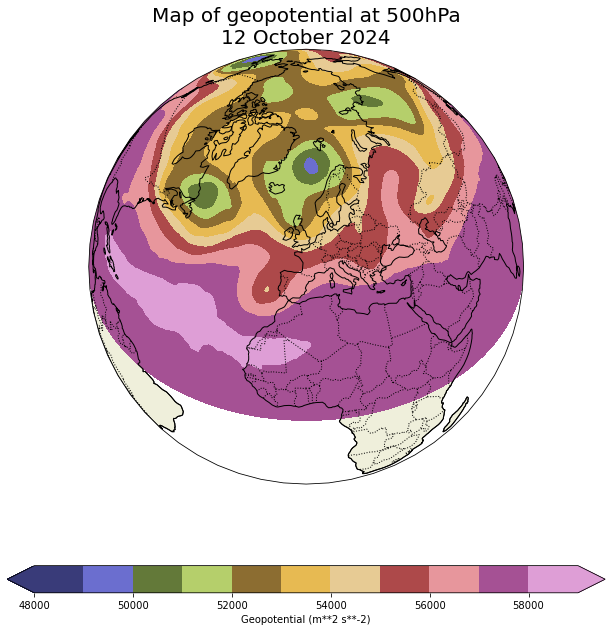

In [8]:
# Load the geopotential data (assuming it's stored in file['z'])
geop = file['z']  # Shape is (651, 1, 361, 1440)

# Geopotential at 500 hPa for the first time step (0) 
geop500 = geop[0, 0, :, :]  

# Latitude et longitude
lon = file.variables['longitude'][:]  # Shape (1440,)
lat = file.variables['latitude'][:]  # Shape (361,)

# Optionnel : se concentrer sur l'hémisphère nord si nécessaire
northern_lat_indices = lat >= 0  # Tableau booléen pour les latitudes >= 0 (hémisphère nord)
lat_nh = lat[northern_lat_indices]  # Latitudes de l'hémisphère nord

# Créer une grille pour les latitudes et les longitudes
lon, lat_nh = np.meshgrid(lon, lat_nh)

# Créer une figure avec une projection orthographique, centrée sur Greenwich (0° longitude, 45° latitude)
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.Orthographic(central_longitude=0, central_latitude=45)})

# Définir les caractéristiques globales
ax.set_global()
ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='k')

# Définir les niveaux de contour pour le géopotentiel (ajuster si nécessaire)
levels = np.arange(48000, 59000 + 100, 1000)

# Date de début
start_date = datetime(2023, 1, 1)

# Fonction d'initialisation pour l'animation
def init():
    contour = ax.contourf(lon, lat_nh, np.zeros_like(lat_nh), levels=levels, transform=ccrs.PlateCarree(), cmap="tab20b", extend='both')
    return contour.collections

# Fonction de mise à jour pour l'animation
def update(frame):
    ax.clear()
    ax.set_global()
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, edgecolor='k')
    
    geop500 = geop[frame, 0, :, :]  # Tranche de géopotentiel pour l'étape de temps actuelle
    geop500_nh = geop500[northern_lat_indices, :]  # Tranche de l'hémisphère nord
    contour = ax.contourf(lon, lat_nh, geop500_nh, levels=levels, transform=ccrs.PlateCarree(), cmap="tab20b", extend='both')
    
    # Calculer la date actuelle
    current_date = start_date + timedelta(days=frame)
    date_str = current_date.strftime('%d %B %Y')
    
    # Ajouter le titre avec la date et une taille de police plus grande
    ax.set_title(f'Map of geopotential at 500hPa\n{date_str}', fontsize=20)
    
    return contour.collections

# Créer l'animation pour les 5 premières tranches et ajuster la vitesse
anim = FuncAnimation(fig, update, frames=range(geop.shape[0]), init_func=init, blit=False, interval=1000)  # interval en millisecondes

# Ajouter la barre de couleur une seule fois
contour = ax.contourf(lon, lat_nh, np.zeros_like(lat_nh), levels=levels, transform=ccrs.PlateCarree(), cmap="tab20b", extend='both')
cbar = plt.colorbar(contour, ax=ax, orientation='horizontal', fraction=0.05, pad=0.15)
cbar.set_label(f'{file["z"].long_name} ({file["z"].units})')

# Sauvegarder l'animation en tant que fichier vidéo
anim.save('geopotential_animation.mp4', writer='ffmpeg', dpi=300)

# Afficher l'animation
plt.show()
